In [1]:
# Although I have created the classification models there are few more analysis that I would like to explore on some of the interesting 
# revelations such as in the year 2014 the largest number of opioid prescription was dispensed by Females 
# I am curious to find out the speciality of the the women and men marked as generous opioid prescription which
# would give me an insight into what sort of illness or conditions causes these prescriptions to escalate
# example is the doctor an orthopedic surgeon or an obstetrician

import csv
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
import sklearn.metrics as sm
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix, average_precision_score, f1_score
import numpy as np

plt.style.use('fivethirtyeight')
plt.rcParams.update({'font.size': 12})
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

fOpoids = "C:/Users/kamakshi.subramaniam/Downloads/ML_HealthCare/opioid_prescription/opioid_drug.csv"
fOverdoses = "C:/Users/kamakshi.subramaniam/Downloads/ML_HealthCare/opioid_prescription/overdoses_death.csv"
fPrescriber = "C:/Users/kamakshi.subramaniam/Downloads/ML_HealthCare/opioid_prescription/prescriber_details.csv"
fDrugDeathTimeLine = "C:/Users/kamakshi.subramaniam/Downloads/ML_HealthCare/opioid_prescription/health-drug-induced-deaths/health-drug-induced-deaths/drug_induced_deaths_1999-2015.csv"

# Opioids information
dfOpioids = pd.read_csv(fOpoids, index_col=None).fillna(value=0)
dfOpioids.columns = ['drug_name', 'generic_name']

# Overdoses
dfOverdoses = pd.read_csv(fOverdoses, index_col=None).fillna(value=0)
# Convert deaths and population to numerical values
dfOverdoses['Deaths'] = dfOverdoses['Deaths'].str.replace(',', '').astype(int)
dfOverdoses['Population'] = dfOverdoses['Population'].str.replace(',', '').astype(int)

# Prescriber information
dfPrescriber = pd.read_csv(fPrescriber, index_col=None).fillna(value=0)

#print("Total number of Opioids")
#print(dfOpioids.groupby('drug_name').size().sort_values(ascending = False))
dfOpioids.head()




,drug_name,generic_name
0,ABSTRAL,FENTANYL CITRATE
1,ACETAMINOPHEN-CODEINE,ACETAMINOPHEN WITH CODEINE
2,ACTIQ,FENTANYL CITRATE
3,ASCOMP WITH CODEINE,CODEINE/BUTALBITAL/ASA/CAFFEIN
4,ASPIRIN-CAFFEINE-DIHYDROCODEIN,DIHYDROCODEINE/ASPIRIN/CAFFEIN


In [2]:
dfOpioids.isnull().sum()

drug_name       0
generic_name    0
dtype: int64

In [3]:
dfPrescriber.head()

,NPI,Gender,State,Credentials,Specialty,ABILIFY,ACETAMINOPHEN.CODEINE,ACYCLOVIR,ADVAIR.DISKUS,AGGRENOX,...,VERAPAMIL.ER,VESICARE,VOLTAREN,VYTORIN,WARFARIN.SODIUM,XARELTO,ZETIA,ZIPRASIDONE.HCL,ZOLPIDEM.TARTRATE,Opioid.Prescriber
0,1710982582,M,TX,DDS,Dentist,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,1245278100,F,AL,MD,General Surgery,0,0,0,0,0,...,0,0,0,0,0,0,0,0,35,1
2,1427182161,F,NY,M.D.,General Practice,0,0,0,0,0,...,0,0,0,0,0,0,0,0,25,0
3,1669567541,M,AZ,MD,Internal Medicine,0,43,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,1679650949,M,NV,M.D.,Hematology/Oncology,0,0,0,0,0,...,0,0,0,0,17,28,0,0,0,1


In [4]:
dfDeathTimeLine = pd.read_csv(fDrugDeathTimeLine, index_col=None).fillna(value=0)
cols_death = ['State', 'Year', 'Deaths', 'Population']
dfDeathTimeLine = dfDeathTimeLine[cols_death]
dfDeathTimeLine['percentage_deaths'] =  round((dfDeathTimeLine.Deaths * 100) / dfDeathTimeLine.Population, 3)
dfDeathTimeLine.head(20)

,State,Year,Deaths,Population,percentage_deaths
0,Alabama,1999,195,4430141,0.004
1,Alabama,2000,232,4447100,0.005
2,Alabama,2001,253,4467634,0.006
3,Alabama,2002,248,4480089,0.006
4,Alabama,2003,255,4503491,0.006
5,Alabama,2004,327,4530729,0.007
6,Alabama,2005,332,4569805,0.007
7,Alabama,2006,466,4628981,0.010
8,Alabama,2007,554,4672840,0.012
9,Alabama,2008,646,4718206,0.014


In [5]:
#print(dfOverdoses.head())
#print(dfOverdoses.dtypes)
#! pip install folium
import folium 
from folium.plugins import MarkerCluster

# % of Deaths related to population
dfOverdoses['per_deaths'] =  (dfOverdoses.Deaths * 100) / dfOverdoses.Population

print("Total number of Deaths - Highest to Lowest")
print(dfOverdoses[['State', 'Population', 'Deaths', 'per_deaths']].sort_values(['per_deaths'], ascending=False))


#Choropleth map
us_states_geo = "C:/Users/kamakshi.subramaniam/Downloads/ML_HealthCare/opioid_prescription/us_states.json"
america_map = folium.Map(location=[37.0902405, -95.7128906], zoom_start = 4, tiles = 'Mapbox Bright')

folium.Choropleth(geo_data = us_states_geo,
                       data = dfOverdoses,
                       columns = ['State', 'per_deaths'],
                       key_on = 'feature.properties.name',
                       fill_color='OrRd',
                       fill_opacity=0.9,
                       nan_fill_color='#ffffff',
                       nan_fill_opacity=0.9,
                       highlight=True,
                       legend_name = 'Deaths due to opioids').add_to(america_map)

marker_cluster = MarkerCluster().add_to(america_map) 

# Add markers over choropleth
for i in range(dfOverdoses.shape[0]):
    location = [dfOverdoses['LAT'][i], dfOverdoses['LNG'][i]]
    tooltip = "State:{}<br> Abbr: {}<br> Click for more".format(dfOverdoses["State"][i], dfOverdoses['Abbrev'][i])
    folium.Marker(location,
                  popup="""
                  <i>Deaths: </i> <br> <b>{}</b> <br> 
                  <i>Population: </i><b><br>{}</b><br>
                  <i>Percentage Death: </i><b><br>{}</b><br>""".format(
                    dfOverdoses['Deaths'][i], 
                    dfOverdoses['Population'][i], 
                    round(dfOverdoses['per_deaths'][i],2)), 
                      tooltip=tooltip).add_to(marker_cluster)

america_map


Total number of Deaths - Highest to Lowest
             State  Population  Deaths  per_deaths
47   West Virginia     1854304     627    0.033813
30      New Mexico     2085287     547    0.026231
28   New Hampshire     1323459     334    0.025237
16        Kentucky     4395295    1077    0.024503
34            Ohio    11570808    2744    0.023715
38    Rhode Island     1051511     247    0.023490
37    Pennsylvania    12773801    2732    0.021388
43            Utah     2900872     603    0.020787
7         Delaware      925749     189    0.020416
35        Oklahoma     3850568     777    0.020179
41       Tennessee     6495978    1269    0.019535
27          Nevada     2790136     545    0.019533
20   Massachusetts     6692824    1289    0.019259
49         Wyoming      582658     109    0.018707
2          Arizona     6626624    1211    0.018275
19        Maryland     5928814    1070    0.018047
13         Indiana     6570902    1172    0.017836
21        Michigan     9895622    1762 

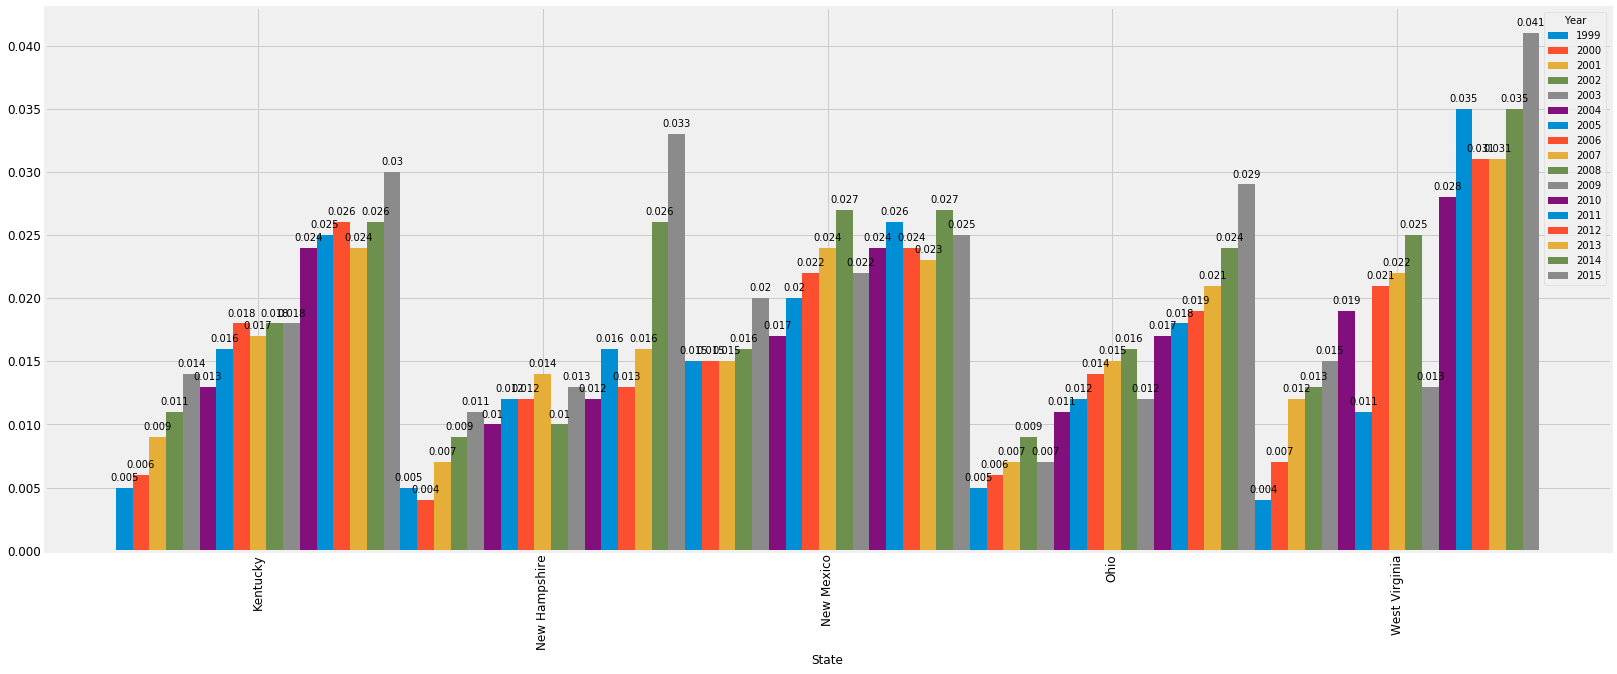

In [6]:
topdeaths = ['West Virginia', 'New Mexico', 'New Hampshire', 'Kentucky', 'Ohio']
dfPlotTopFive = dfDeathTimeLine.loc[dfDeathTimeLine['State'].isin(topdeaths)]

axtopfive = dfPlotTopFive.pivot(index='State', columns='Year', values='percentage_deaths').plot(kind='bar', width=1, figsize=(25,10), fontsize=12)
for p in axtopfive.patches:
    b = p.get_bbox()
    val = b.y1    
    axtopfive.annotate(val, ((b.x0 + b.x1)/2, b.y1), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')



In [7]:
dfPlotTopFive[dfPlotTopFive['State'] == 'West Virginia'] 

,State,Year,Deaths,Population,percentage_deaths
816,West Virginia,1999,80,1811799,0.004
817,West Virginia,2000,122,1808344,0.007
818,West Virginia,2001,217,1801481,0.012
819,West Virginia,2002,237,1805414,0.013
820,West Virginia,2003,279,1812295,0.015
821,West Virginia,2004,347,1816438,0.019
822,West Virginia,2005,197,1820492,0.011
823,West Virginia,2006,378,1827912,0.021
824,West Virginia,2007,405,1834052,0.022
825,West Virginia,2008,468,1840310,0.025


In [8]:
dfPlotTopFive[dfPlotTopFive['State'] == 'New Mexico'] 

,State,Year,Deaths,Population,percentage_deaths
527,New Mexico,1999,275,1808082,0.015
528,New Mexico,2000,281,1819046,0.015
529,New Mexico,2001,277,1831690,0.015
530,New Mexico,2002,301,1855309,0.016
531,New Mexico,2003,373,1877574,0.020
532,New Mexico,2004,331,1903808,0.017
533,New Mexico,2005,385,1932274,0.020
534,New Mexico,2006,435,1962137,0.022
535,New Mexico,2007,471,1990070,0.024
536,New Mexico,2008,534,2010662,0.027


In [9]:
dfPlotTopFive[dfPlotTopFive['State'] == 'New Hampshire'] 

,State,Year,Deaths,Population,percentage_deaths
493,New Hampshire,1999,62,1222014,0.005
494,New Hampshire,2000,49,1235786,0.004
495,New Hampshire,2001,83,1255517,0.007
496,New Hampshire,2002,114,1269089,0.009
497,New Hampshire,2003,137,1279840,0.011
498,New Hampshire,2004,128,1290121,0.010
499,New Hampshire,2005,152,1298492,0.012
500,New Hampshire,2006,160,1308389,0.012
501,New Hampshire,2007,187,1312540,0.014
502,New Hampshire,2008,129,1315906,0.010


In [10]:
dfPlotTopFive[dfPlotTopFive['State'] == 'Kentucky'] 

,State,Year,Deaths,Population,percentage_deaths
289,Kentucky,1999,215,4018053,0.005
290,Kentucky,2000,257,4041769,0.006
291,Kentucky,2001,370,4068132,0.009
292,Kentucky,2002,451,4089875,0.011
293,Kentucky,2003,588,4117170,0.014
294,Kentucky,2004,559,4146101,0.013
295,Kentucky,2005,662,4182742,0.016
296,Kentucky,2006,766,4219239,0.018
297,Kentucky,2007,722,4256672,0.017
298,Kentucky,2008,779,4289878,0.018


In [11]:
dfPlotTopFive[dfPlotTopFive['State'] == 'Ohio'] 

,State,Year,Deaths,Population,percentage_deaths
595,Ohio,1999,534,11335454,0.005
596,Ohio,2000,625,11353140,0.006
597,Ohio,2001,808,11387404,0.007
598,Ohio,2002,1025,11407889,0.009
599,Ohio,2003,852,11434788,0.007
600,Ohio,2004,1266,11452251,0.011
601,Ohio,2005,1382,11463320,0.012
602,Ohio,2006,1606,11481213,0.014
603,Ohio,2007,1691,11500468,0.015
604,Ohio,2008,1811,11515391,0.016


In [12]:
# dfPrescriber is the main dataframe
# Checking for nulls
dfPrescriber.isnull().sum()

NPI                               0
Gender                            0
State                             0
Credentials                       0
Specialty                         0
ABILIFY                           0
ACETAMINOPHEN.CODEINE             0
ACYCLOVIR                         0
ADVAIR.DISKUS                     0
AGGRENOX                          0
ALENDRONATE.SODIUM                0
ALLOPURINOL                       0
ALPRAZOLAM                        0
AMIODARONE.HCL                    0
AMITRIPTYLINE.HCL                 0
AMLODIPINE.BESYLATE               0
AMLODIPINE.BESYLATE.BENAZEPRIL    0
AMOXICILLIN                       0
AMOX.TR.POTASSIUM.CLAVULANATE     0
AMPHETAMINE.SALT.COMBO            0
ATENOLOL                          0
ATORVASTATIN.CALCIUM              0
AVODART                           0
AZITHROMYCIN                      0
BACLOFEN                          0
BD.ULTRA.FINE.PEN.NEEDLE          0
BENAZEPRIL.HCL                    0
BENICAR                     

In [13]:
dfPrescriber.shape

(25000, 256)

In [14]:
# dfPrescriber.head()
# dfPrescriber.count()
# PR, AE, ZZ, GU, AA or VI not included in the overdose section
# Remove states that does not give us any useful information
remove_state = ['PR', 'AE', 'ZZ', 'GU', 'AA', 'VI']
dfPrescriber = dfPrescriber[~dfPrescriber['State'].isin(remove_state)]
print("________________________________________________")
print("Prescribers' States whose patients overdosed")
print("________________________________________________")
print(list(pd.Series(dfPrescriber.State.unique()).sort_values()))
print("________________________________________________")
print("Overdoses state")
print("________________________________________________")
print(list(pd.Series(dfOverdoses.Abbrev.unique()).sort_values()))
print("________________________________________________")
print("Prescribers' Speciality whose patients overdosed")
print("________________________________________________")
print(dfPrescriber.Specialty)



________________________________________________
Prescribers' States whose patients overdosed
________________________________________________
['AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA', 'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM', 'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY']
________________________________________________
Overdoses state
________________________________________________
['AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA', 'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM', 'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY']
________________________________________________
Prescribers' Speciality whose patients overdosed
_____________________________________

['Gender', 'State', 'Specialty', 'ACETAMINOPHEN.CODEINE', 'FENTANYL', 'HYDROCODONE.ACETAMINOPHEN', 'HYDROMORPHONE.HCL', 'METHADONE.HCL', 'MORPHINE.SULFATE', 'MORPHINE.SULFATE.ER', 'OXYCODONE.ACETAMINOPHEN', 'OXYCODONE.HCL', 'OXYCONTIN', 'TRAMADOL.HCL']
Total Prescriptuon per State:  (51, 2)
Total Prescriptuon per State & Gender:  (102, 3)
Merged dataset with population for State totals:  (50, 4)


C:\Users\kamakshi.subramaniam\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


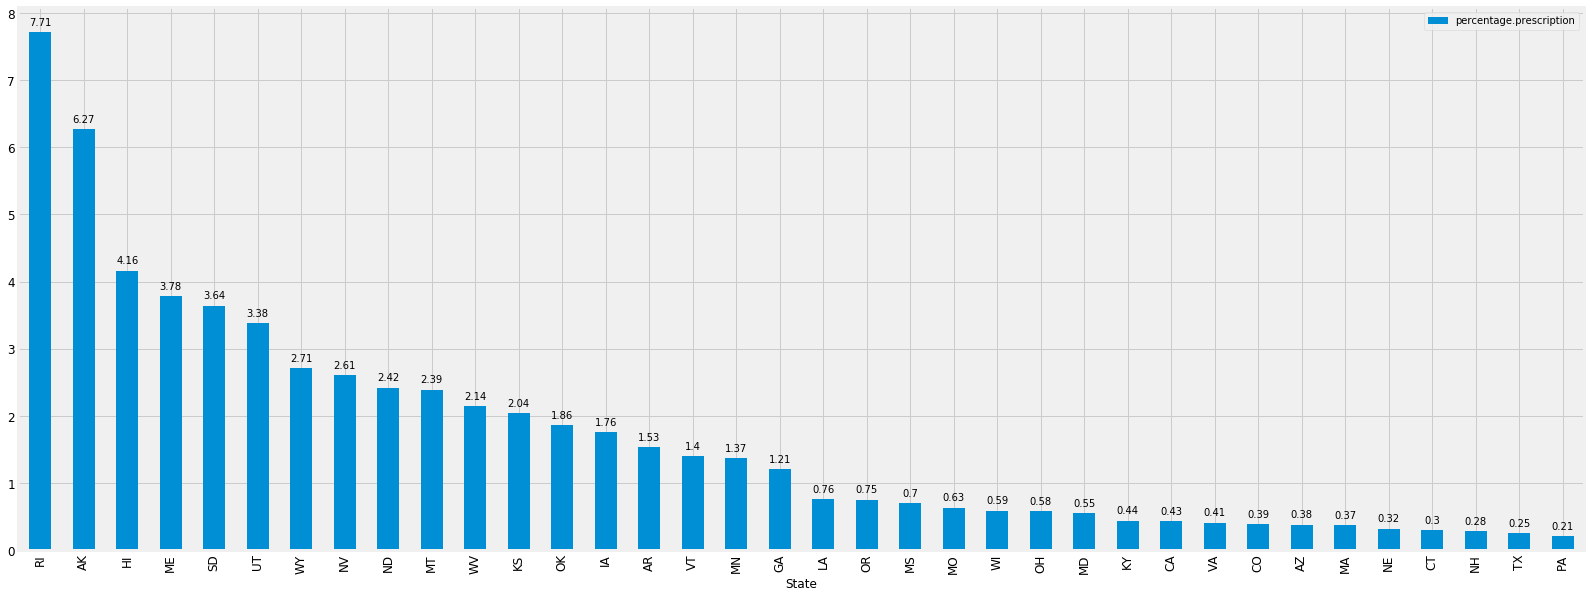

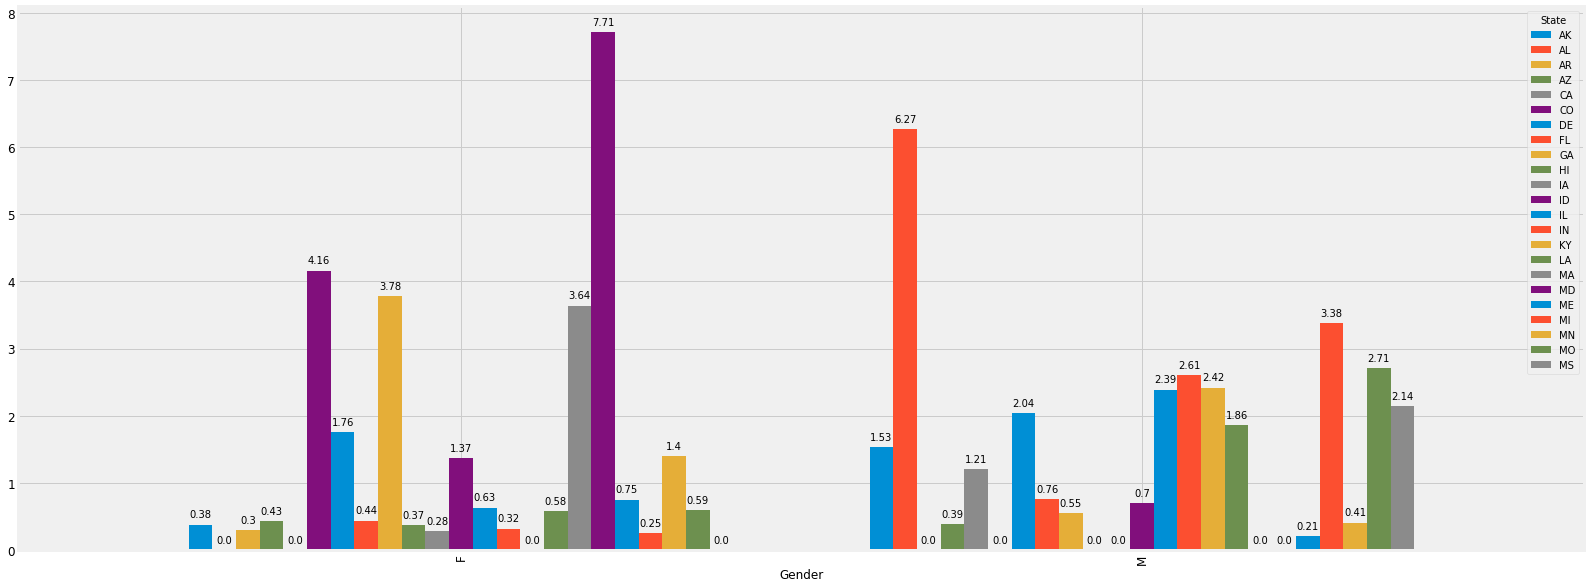

In [15]:
# Pick opioid prescribers by state and check to see if the overdose details tallies with the prescription details
import re
# Remove spaces as it is the column name 
# Matching name in opioid file with the column names in prescriber.csv AMIODARONE.HCL
opioid_name = dfOpioids['drug_name'].apply(lambda x:re.sub("\ |-", ".", str(x)))
#for s in opioid_name:
    #print(s)

# Opioid prescriber tells us if the doctor prescribes opioids
# Data set contains columns that are both opioids and non opioids 
# remove non opioid columns from the prescription dataset
columns = dfPrescriber.columns
add_cols = set(columns).intersection(set(opioid_name))
lst_cols_add = ['State', 'Gender', 'Specialty']
    
opioid_cols=[]
for col in columns:
    if col in add_cols:
        opioid_cols.append(col)
    elif col in lst_cols_add:
        opioid_cols.append(col)
    else:
        pass
        
print(list(opioid_cols))

# Gather the opioid columns along with State and Gender
dfOpioidsSub = dfPrescriber[opioid_cols]

# Group by State column
dfOpioidsSub['total_prescription'] = dfOpioidsSub.iloc[:, 2:13].sum(axis=1)
dfPrescriptions = dfOpioidsSub[['State', 'total_prescription']].groupby(['State']).sum().reset_index()
print("Total Prescriptuon per State: " , dfPrescriptions.shape)

#group by gender and state column
dfPrescriptionsGender = dfOpioidsSub[['State', 'Gender', 'total_prescription']].groupby(['State', 'Gender']).sum().reset_index()
print("Total Prescriptuon per State & Gender: ", dfPrescriptionsGender.shape)


# Merge with overdose dataframe to grab the population field
dfStatePop = dfOverdoses[['Population', 'Abbrev', 'LAT', 'LNG']]
dfStatePop = dfStatePop.rename(columns={ dfStatePop.columns[1]: "State" })
print("Merged dataset with population for State totals: ", dfStatePop.shape)
#print(dfStatePop.dtypes)


# total prescription without gender
dfTotalPreByState = dfStatePop.merge(dfPrescriptions)
dfTotalPreByState['percentage.prescription'] =  round((dfPrescriptions.total_prescription * 100) / dfStatePop.Population, 2)


# Total prescriptions by gender
dfTotalPreByStateGender = dfStatePop.merge(dfPrescriptionsGender)
dfTotalPreByStateGender['percentage.prescription'] =  round((dfPrescriptions.total_prescription * 100) / dfStatePop.Population, 2)


# Bar charts
# Prescriptions without gender
dfplot_presc = dfTotalPreByState[['State', 'percentage.prescription']].sort_values(['percentage.prescription'], ascending=False)
dfplot_presc = dfplot_presc[dfplot_presc['percentage.prescription'] > 0.2] 
#print (dfplot_presc.dtypes)
ax = dfplot_presc.plot(x='State', y='percentage.prescription', kind='bar', figsize=(25,10), fontsize=12)
for p in ax.patches:
    b = p.get_bbox()
    val = b.y1    
    ax.annotate(val, ((b.x0 + b.x1)/2, b.y1), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')


# prescriptions by gender
dfplot_presc_gender = dfTotalPreByStateGender[['State', 'Gender', 'percentage.prescription']].sort_values(['percentage.prescription'], ascending=False)
dfplot_presc_gender = dfplot_presc_gender[dfplot_presc_gender['percentage.prescription'] > 0.2] 
axg = dfplot_presc_gender.pivot(index='Gender', columns='State', values='percentage.prescription').plot(kind='bar', width=0.8, figsize=(25,10), fontsize=12)
for p in axg.patches:
    b = p.get_bbox()
    val = b.y1    
    axg.annotate(val, ((b.x0 + b.x1)/2, b.y1), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

#Choropleth map for all prescriptions without gender specifications
pres_map = folium.Map(location=[37.0902405, -95.7128906], zoom_start = 4, tiles = 'Mapbox Bright')

folium.Choropleth(geo_data = us_states_geo,
                       data = dfTotalPreByState,
                       hover_name="State",
                       columns = ['State', 'percentage.prescription'],
                       key_on = 'feature.id',
                       fill_color='OrRd',
                       fill_opacity=0.9,
                       nan_fill_color='#ffffff',
                       nan_fill_opacity=0.9,
                       highlight=True,
                       legend_name = 'Opioid Prescriptions').add_to(pres_map)

marker_cluster = MarkerCluster().add_to(pres_map) 

# Add markers over choropleth
for i in range(dfTotalPreByState.shape[0]):
    location = [dfTotalPreByState['LAT'][i], dfTotalPreByState['LNG'][i]]
    tooltip = "State:{}<br> Click for more".format(dfTotalPreByState["State"][i])
    folium.Marker(location,
                  popup="""
                  <i>Prescription: </i> <br> <b>{}</b> <br> 
                  <i>Population: </i><b><br>{}</b><br>
                  <i>Percentage Prescription by pop: </i><b><br>{}</b><br>""".format(
                    dfTotalPreByState['total_prescription'][i], 
                    dfTotalPreByState['Population'][i], 
                    round(dfTotalPreByState['percentage.prescription'][i],2)), 
                      tooltip=tooltip).add_to(marker_cluster)

pres_map



In [16]:
#How much of the dataset is male vs female
# Grouping by gender and the total sum of prescibers
print("***************************")
print("Male and Female prescribers")
print("***************************")
print(dfPrescriber[dfPrescriber['Opioid.Prescriber'] == 1].groupby('Gender').size() / dfPrescriber[dfPrescriber['Opioid.Prescriber'] == 1].groupby('Gender').size().sum())

print("**********************")
print("Specialities")
print("**********************")
print(list(dfPrescriber[dfPrescriber['Opioid.Prescriber'] == 1].Specialty.unique()))


***************************
Male and Female prescribers
***************************
Gender
F    0.350598
M    0.649402
dtype: float64
**********************
Specialities
**********************
['Dentist', 'General Surgery', 'Internal Medicine', 'Hematology/Oncology', 'Family Practice', 'Obstetrics/Gynecology', 'Podiatry', 'Student in an Organized Health Care Education/Training Program', 'Nurse Practitioner', 'Neurology', 'Physician Assistant', 'Rheumatology', 'Urology', 'Emergency Medicine', 'Psychiatry', 'Cardiology', 'Thoracic Surgery', 'Oral Surgery (dentists only)', 'Anesthesiology', 'Orthopedic Surgery', 'General Practice', 'Ophthalmology', 'Otolaryngology', 'Gastroenterology', 'Physical Medicine and Rehabilitation', 'Maxillofacial Surgery', 'Preventive Medicine', 'Infectious Disease', 'Neuropsychiatry', 'Hand Surgery', 'Pulmonary Disease', 'Hospice and Palliative Care', 'Medical Oncology', 'Plastic and Reconstructive Surgery', 'Cardiac Electrophysiology', 'Colorectal Surgery (for

In [17]:
# Opioid prescriber vs non prescriber
# Score seems to indicate that it is not an imbalanced data set
# 41.28% are non prescribers
# 58.71% are prescribers
print("---------------------------------------------")
print("% of Opioid Prescribers vs  did not opioid prescibers")
print("---------------------------------------------")
count_not_opioid = len(dfPrescriber[dfPrescriber['Opioid.Prescriber'] == 0])
count_opioid = len(dfPrescriber[dfPrescriber['Opioid.Prescriber'] == 1])
pct_of_not_opioid = count_not_opioid/(count_not_opioid + count_opioid)
print("percentage of non opioid prescribers ", pct_of_not_opioid * 100)
pct_of_opioid = count_opioid/(count_not_opioid + count_opioid)
print("percentage of opioid prescribers ", pct_of_opioid * 100)
#print(dfPrescriber.groupby('Opioid.Prescriber').size() / dfPrescriber.groupby('Opioid.Prescriber').size().sum())
print(dfPrescriber.shape)

# Drop columns not required- credentials is the abbreviated form of specialty
dfPrescriber = dfPrescriber.drop(['NPI', 'Credentials'], axis = 1)



---------------------------------------------
% of Opioid Prescribers vs  did not opioid prescibers
---------------------------------------------
percentage of non opioid prescribers  41.28195807585121
percentage of opioid prescribers  58.71804192414879
(24759, 256)


Not Opioid Prescribers:  10221
Opioid Prescribers:  14538


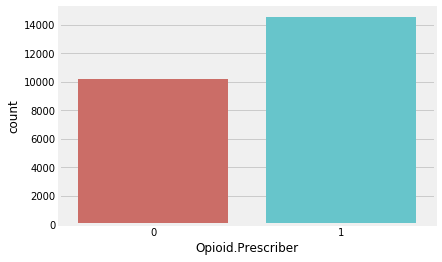

In [18]:
# Plotting the target variable
#print(dfPrescriber.Opioid.Prescriber.value_counts())
# We have more opioid prescribers in the data set and non opioid prescribers
# The data is horribly imbalanced for the train and test split
print("Not Opioid Prescribers: " , count_not_opioid)
print("Opioid Prescribers: " , count_opioid)
sns.countplot(x = 'Opioid.Prescriber', data = dfPrescriber, palette = 'hls')
plt.show()

In [19]:
import re
# Remove spaces as it is the column name 
# Matching name in opioid file with the column names in prescriber.csv AMIODARONE.HCL
opioid_name = dfOpioids['drug_name'].apply(lambda x:re.sub("\ |-", ".", str(x)))
#for s in opioid_name:
    #print(s)

# Opioid prescriber tells us if the doctor prescribes opioids
# Data set contains columns that are both opioids and non opioids 
# remove non opioid columns from the prescription dataset
columns = dfPrescriber.columns
remove_cols = set(columns).intersection(set(opioid_name))
    
non_opioid_cols=[]
for col in columns:
    if col in remove_cols:
        pass
    else:
        non_opioid_cols.append(col)
        
non_opioid_cols




['Gender',
 'State',
 'Specialty',
 'ABILIFY',
 'ACYCLOVIR',
 'ADVAIR.DISKUS',
 'AGGRENOX',
 'ALENDRONATE.SODIUM',
 'ALLOPURINOL',
 'ALPRAZOLAM',
 'AMIODARONE.HCL',
 'AMITRIPTYLINE.HCL',
 'AMLODIPINE.BESYLATE',
 'AMLODIPINE.BESYLATE.BENAZEPRIL',
 'AMOXICILLIN',
 'AMOX.TR.POTASSIUM.CLAVULANATE',
 'AMPHETAMINE.SALT.COMBO',
 'ATENOLOL',
 'ATORVASTATIN.CALCIUM',
 'AVODART',
 'AZITHROMYCIN',
 'BACLOFEN',
 'BD.ULTRA.FINE.PEN.NEEDLE',
 'BENAZEPRIL.HCL',
 'BENICAR',
 'BENICAR.HCT',
 'BENZTROPINE.MESYLATE',
 'BISOPROLOL.HYDROCHLOROTHIAZIDE',
 'BRIMONIDINE.TARTRATE',
 'BUMETANIDE',
 'BUPROPION.HCL.SR',
 'BUPROPION.XL',
 'BUSPIRONE.HCL',
 'BYSTOLIC',
 'CARBAMAZEPINE',
 'CARBIDOPA.LEVODOPA',
 'CARISOPRODOL',
 'CARTIA.XT',
 'CARVEDILOL',
 'CEFUROXIME',
 'CELEBREX',
 'CEPHALEXIN',
 'CHLORHEXIDINE.GLUCONATE',
 'CHLORTHALIDONE',
 'CILOSTAZOL',
 'CIPROFLOXACIN.HCL',
 'CITALOPRAM.HBR',
 'CLINDAMYCIN.HCL',
 'CLOBETASOL.PROPIONATE',
 'CLONAZEPAM',
 'CLONIDINE.HCL',
 'CLOPIDOGREL',
 'CLOTRIMAZOLE.BETAMETHA

In [20]:
dfPrescriber.shape

(24759, 254)

In [21]:
df = dfPrescriber[non_opioid_cols]
print(df.shape)

# Convert categorical columns to numeric values
cat_columns=['Gender','State','Specialty']

# Scores by dropping all of opioids prescriptions
for col in cat_columns:
    df[col]= pd.factorize(df[col], sort=True)[0]

# Scores by retaining all of opioids prescriptions is much higher so keeping the opioid columns
for col in cat_columns:
    dfPrescriber[col]= pd.factorize(df[col], sort=True)[0]
    
df.head()

(24759, 243)


C:\Users\kamakshi.subramaniam\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


,Gender,State,Specialty,ABILIFY,ACYCLOVIR,ADVAIR.DISKUS,AGGRENOX,ALENDRONATE.SODIUM,ALLOPURINOL,ALPRAZOLAM,...,VERAPAMIL.ER,VESICARE,VOLTAREN,VYTORIN,WARFARIN.SODIUM,XARELTO,ZETIA,ZIPRASIDONE.HCL,ZOLPIDEM.TARTRATE,Opioid.Prescriber
0,1,43,18,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,1,28,0,0,0,0,0,0,134,...,0,0,0,0,0,0,0,0,35,1
2,0,34,27,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,25,0
3,1,3,41,0,0,0,0,21,0,0,...,0,0,0,0,0,0,0,0,0,1
4,1,33,35,0,0,0,0,0,0,0,...,0,0,0,0,17,28,0,0,0,1


In [22]:
# Split the data to testing and training sets (test => 30%, train => 70%)
# This is a very sensitive model so we will proceed to create a balanceed Test-Train split of 50% 
#!pip install imblearn 
from imblearn.over_sampling import SMOTE
target_col = ['Opioid.Prescriber']

# Gender Included
X = df.drop(target_col, axis = 1)
# Removing gender increases prediction score- very low correlation between gender and opioid prescription
#X = X.drop(['Gender'], axis = 1)
Y = df[target_col]

#Split the dataset as test and training data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

#Check the numbers of data
print("******************************************************************")
print("Test-Train split before Synthetic Minority Over-sampling Technique")
print("******************************************************************")
print("length of oversampled data is: ", len(X_train))
print("Number of no opioid prescriber in oversampled data: ", len(Y_train[Y_train['Opioid.Prescriber'] == 0]))
print("Number of opioid prescriber: ", len(Y_train[Y_train['Opioid.Prescriber'] == 1]))
print("Proportion of no opioid prescibers in sample: ", round(len(Y_train[Y_train['Opioid.Prescriber'] == 0])/len(X_train), 2))
print("Proportion of opioid prescriber data in sample:  ", round(len(Y_train[Y_train['Opioid.Prescriber'] == 1])/len(X_train), 2))

#Synthetic Minority Over-sampling Technique to balance the dataset
sm = SMOTE(random_state = 42)
columns = X_train.columns
smX_train, smY_train = sm.fit_sample(X_train, Y_train.values.ravel())
# convert numpy array back to dataframe
X_train = pd.DataFrame(data = smX_train, columns=columns )
Y_train = pd.DataFrame(data = smY_train, columns=target_col)

#Check the numbers of data
print("*****************************************************************")
print("Test-Train split after Synthetic Minority Over-sampling Technique")
print("*****************************************************************")
print("length of oversampled data is: ", len(X_train))
print("Number of no opioid prescriber in oversampled data: ", len(Y_train[Y_train['Opioid.Prescriber'] == 0]))
print("Number of opioid prescriber: ", len(Y_train[Y_train['Opioid.Prescriber'] == 1]))
print("Proportion of no opioid prescibers in sample: ", len(Y_train[Y_train['Opioid.Prescriber'] == 0])/len(X_train))
print("Proportion of opioid prescriber data in sample:  ", len(Y_train[Y_train['Opioid.Prescriber'] == 1])/len(X_train))


Using TensorFlow backend.


******************************************************************
Test-Train split before Synthetic Minority Over-sampling Technique
******************************************************************
length of oversampled data is:  17331
Number of no opioid prescriber in oversampled data:  7154
Number of opioid prescriber:  10177
Proportion of no opioid prescibers in sample:  0.41
Proportion of opioid prescriber data in sample:   0.59
*****************************************************************
Test-Train split after Synthetic Minority Over-sampling Technique
*****************************************************************
length of oversampled data is:  20354
Number of no opioid prescriber in oversampled data:  10177
Number of opioid prescriber:  10177
Proportion of no opioid prescibers in sample:  0.5
Proportion of opioid prescriber data in sample:   0.5


Predicts the likelihood that a certain type of doctor prescribes opioids
--------------------------
Logistic Regression
--------------------------
[[2716  351]
 [1516 2845]]


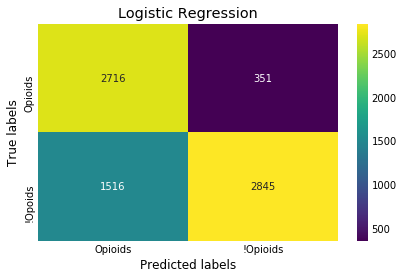

--------------------------
Random forest classifier
--------------------------
[[2467  600]
 [ 764 3597]]


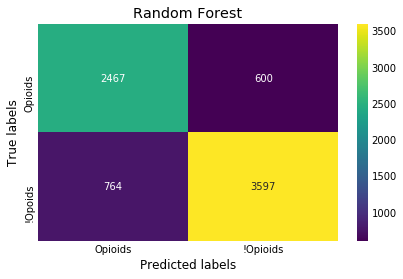

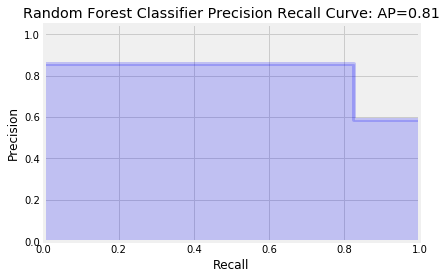

--------------------------
Decision Tree Classifier
--------------------------
[[2197  870]
 [ 835 3526]]


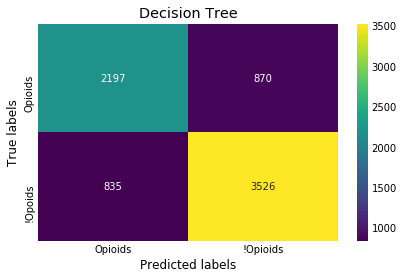

--------------------------
Gaussian Naive Bayes
--------------------------
[[2813  254]
 [2567 1794]]


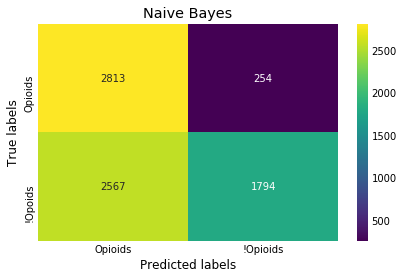

--------------------------
Gradient Boosting
--------------------------
[[2656  411]
 [ 929 3432]]


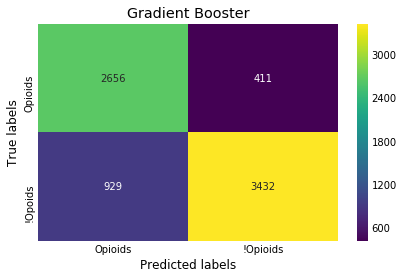

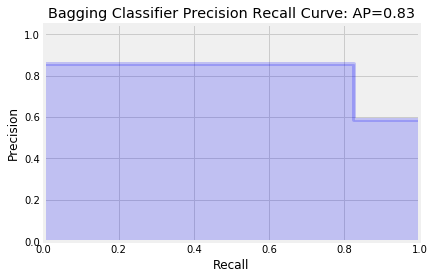

--------------------------
KNN
--------------------------
[[2364  703]
 [1075 3286]]


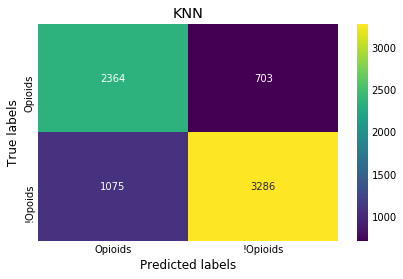

--------------------------
Linear Discriminant
--------------------------
[[2760  307]
 [1903 2458]]


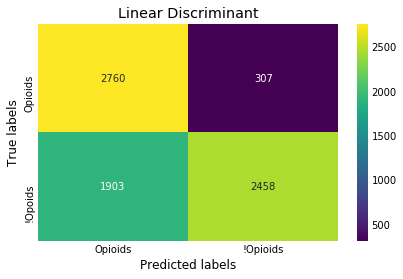

--------------------------
Bagging Classifier
--------------------------
[[2408  659]
 [ 770 3591]]


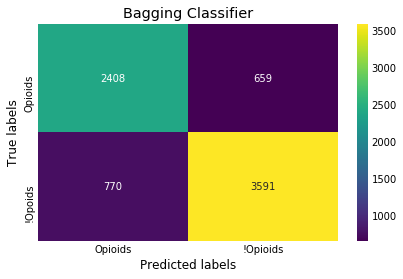

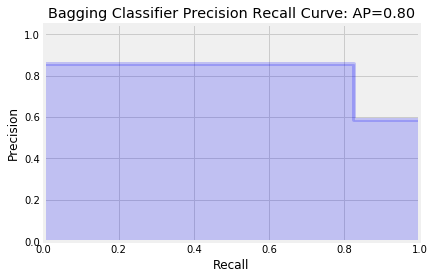

,Evaluation Metrics,Score,Algorithm
0,Accuracy Score,0.748654,Logistic Regression
1,Recall Score,0.652373,Logistic Regression
2,Average precision Score,0.784819,Logistic Regression
0,Accuracy Score,0.816370,Random Forest Classifier
1,Recall Score,0.824811,Random Forest Classifier
2,Average precision Score,0.809751,Random Forest Classifier
0,Accuracy Score,0.770463,Decision Tree Classifier
1,Recall Score,0.808530,Decision Tree Classifier
2,Average precision Score,0.760929,Decision Tree Classifier
0,Accuracy Score,0.620221,Naive Bayes


In [23]:
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix, average_precision_score, f1_score
from sklearn.metrics import precision_recall_curve

print("Predicts the likelihood that a certain type of doctor prescribes opioids")

# calling the classification algorithms for predictions
#Logistic regression
print("--------------------------")
print("Logistic Regression")
print("--------------------------")
lr = LogisticRegression(random_state=0, solver='liblinear', max_iter=1500)
lrmodel = lr.fit(X_train, Y_train.values.reshape(-1,))
Y_predict_lr = lrmodel.predict(X_test)

accuracyscore = accuracy_score(Y_test.values, Y_predict_lr)
recallscore = recall_score(Y_test.values, Y_predict_lr)
avgprecisionscore = average_precision_score(Y_test.values, Y_predict_lr)
data = [['Accuracy Score', accuracyscore, 'Logistic Regression'], 
        ['Recall Score', recallscore, 'Logistic Regression'], 
        ['Average precision Score', avgprecisionscore, 'Logistic Regression']] 
# Create the pandas DataFrame 
dflr = pd.DataFrame(data, columns = ['Evaluation Metrics', 'Score', 'Algorithm']) 
  
cm = confusion_matrix(Y_test, Y_predict_lr)
# Diagonal values represent accurate predictions, while non-diagonal elements are inaccurate predictions. 
# In the output, 2565 and 3111 are actual predictions, and 502 and 1250 are incorrect predictions.
#[True Negatives        False Positives 
# False Negatives       True Positives]
#TP: the cases for which the classifier algorithm predicted ‘overdosing prescriber’ which was correct.
#TN: the cases for which the classifier predicted ‘not an overdose prescriber’ and it wasn't an overdosing prescriber
#FP: the cases for which the classifier predicted ‘overdosing prescriber’ but the it wasn't.
#FN: the cases for which the classifier predicted ‘not an overdosing prescriber’ but the emails were actually overdosing prescribers.
print(cm)
#Plot the confusion matrix
ax= plt.subplot()
sns.heatmap(pd.DataFrame(cm), annot=True, ax = ax, cmap="viridis" ,fmt='g'); 
# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels'); 
ax.set_title('Logistic Regression'); 
ax.xaxis.set_ticklabels(['Opioids', '!Opioids']); 
ax.yaxis.set_ticklabels(['Opioids', '!Opoids']);
plt.show()


#Random forest classifier
print("--------------------------")
print("Random forest classifier")
print("--------------------------")
rfmodel = RandomForestClassifier()
rfmodel.fit(X_train, Y_train.values.reshape(-1,))
Y_predict_rf = rfmodel.predict(X_test)
accuracyscore = accuracy_score(Y_test.values, Y_predict_rf)
recallscore = recall_score(Y_test.values, Y_predict_rf)
avgprecisionscore = average_precision_score(Y_test.values, Y_predict_rf)
data = [['Accuracy Score', accuracyscore, 'Random Forest Classifier'], 
        ['Recall Score', recallscore, 'Random Forest Classifier'], 
        ['Average precision Score', avgprecisionscore, 'Random Forest Classifier']] 
# Create the pandas DataFrame 
dfrf = pd.DataFrame(data, columns = ['Evaluation Metrics', 'Score', 'Algorithm']) 

cm = confusion_matrix(Y_test, Y_predict_rf)
print(cm)
ax= plt.subplot()
sns.heatmap(pd.DataFrame(cm), annot=True, ax = ax, cmap="viridis" ,fmt='g');
# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Random Forest'); 
ax.xaxis.set_ticklabels(['Opioids', '!Opioids']); 
ax.yaxis.set_ticklabels(['Opioids', '!Opoids']);
plt.show()

# Precision Recall Curve
precision, recall, threshold = precision_recall_curve(Y_test, Y_predict_rf)
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Random Forest Classifier Precision Recall Curve: AP={0:0.2f}'.format(avgprecisionscore))
plt.show()


#Decision Tree Classifier
print("--------------------------")
print("Decision Tree Classifier")
print("--------------------------")
dt = DecisionTreeClassifier(random_state=12)
dtmodel = dt.fit(X_train, Y_train.values.reshape(-1,))
Y_predict_dt = dtmodel.predict(X_test)
accuracyscore = accuracy_score(Y_test.values, Y_predict_dt)
recallscore = recall_score(Y_test.values, Y_predict_dt)
avgprecisionscore = average_precision_score(Y_test.values, Y_predict_dt)
data = [['Accuracy Score', accuracyscore, 'Decision Tree Classifier'], 
        ['Recall Score', recallscore, 'Decision Tree Classifier'], 
        ['Average precision Score', avgprecisionscore, 'Decision Tree Classifier']] 
# Create the pandas DataFrame 
dfdt = pd.DataFrame(data, columns = ['Evaluation Metrics', 'Score', 'Algorithm']) 

cm = confusion_matrix(Y_test, Y_predict_dt)
print(cm)
ax= plt.subplot()
sns.heatmap(pd.DataFrame(cm), annot=True, ax = ax, cmap="viridis", fmt='g');
# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Decision Tree'); 
ax.xaxis.set_ticklabels(['Opioids', '!Opioids']); 
ax.yaxis.set_ticklabels(['Opioids', '!Opoids']);
plt.show()



#Naive bayes
print("--------------------------")
print("Gaussian Naive Bayes")
print("--------------------------")
gnb = GaussianNB()
modelgnb = gnb.fit(X_train, Y_train.values.reshape(-1,))
Y_predict_nb = modelgnb.predict(X_test)
accuracyscore = accuracy_score(Y_test.values, Y_predict_nb)
recallscore = recall_score(Y_test.values, Y_predict_nb)
avgprecisionscore = average_precision_score(Y_test.values, Y_predict_nb)
data = [['Accuracy Score', accuracyscore, 'Naive Bayes'], 
        ['Recall Score', recallscore, 'Naive Bayes'], 
        ['Average precision Score', avgprecisionscore, 'Naive Bayes']] 
# Create the pandas DataFrame 
dfnb = pd.DataFrame(data, columns = ['Evaluation Metrics', 'Score', 'Algorithm']) 

cm = confusion_matrix(Y_test, Y_predict_nb)
print(cm)
ax= plt.subplot()
sns.heatmap(pd.DataFrame(cm), annot=True, ax = ax, cmap="viridis" ,fmt='g');
# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Naive Bayes'); 
ax.xaxis.set_ticklabels(['Opioids', '!Opioids']); 
ax.yaxis.set_ticklabels(['Opioids', '!Opoids']);
plt.show()



# Gradient Boosting
print("--------------------------")
print("Gradient Boosting")
print("--------------------------")
gb = GradientBoostingClassifier(n_estimators=200)
modelgb = gb.fit(X_train, Y_train.values.reshape(-1,))
Y_predict_gb = modelgb.predict(X_test)
accuracyscore = accuracy_score(Y_test.values, Y_predict_gb)
recallscore = recall_score(Y_test.values, Y_predict_gb)
avgprecisionscore = average_precision_score(Y_test.values, Y_predict_gb)
data = [['Accuracy Score', accuracyscore, 'Gradient Boosting'], 
        ['Recall Score', recallscore, 'Gradient Boosting'], 
        ['Average precision Score', avgprecisionscore, 'Gradient Boosting']] 
# Create the pandas DataFrame 
dfgb = pd.DataFrame(data, columns = ['Evaluation Metrics', 'Score', 'Algorithm']) 

cm = confusion_matrix(Y_test, Y_predict_gb)
print(cm)
ax= plt.subplot()
sns.heatmap(pd.DataFrame(cm), annot=True, ax = ax, cmap="viridis" ,fmt='g');
# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Gradient Booster'); 
ax.xaxis.set_ticklabels(['Opioids', '!Opioids']); 
ax.yaxis.set_ticklabels(['Opioids', '!Opoids']);
plt.show()

# Precision Recall Curve
precision, recall, threshold = precision_recall_curve(Y_test, Y_predict_rf)
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Bagging Classifier Precision Recall Curve: AP={0:0.2f}'.format(avgprecisionscore))
plt.show()


# KNN
print("--------------------------")
print("KNN")
print("--------------------------")
# Avoiding overfitting issue with Principle Dimensinality reduction to see if the model score improves

knn = KNeighborsClassifier(n_neighbors=5)
modelknn = knn.fit(X_train, Y_train.values.reshape(-1,))
Y_predict_knn = modelknn.predict(X_test)
accuracyscore = accuracy_score(Y_test.values, Y_predict_knn)
recallscore = recall_score(Y_test.values, Y_predict_knn)
avgprecisionscore = average_precision_score(Y_test.values, Y_predict_knn)
data = [['Accuracy Score', accuracyscore, 'KNN'], 
        ['Recall Score', recallscore, 'KNN'], 
        ['Average precision Score', avgprecisionscore, 'KNN']] 
# Create the pandas DataFrame 
dfknn = pd.DataFrame(data, columns = ['Evaluation Metrics', 'Score', 'Algorithm']) 

cm = confusion_matrix(Y_test, Y_predict_knn)
print(cm)
ax= plt.subplot()
sns.heatmap(pd.DataFrame(cm), annot=True, ax = ax, cmap="viridis" ,fmt='g');
# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('KNN'); 
ax.xaxis.set_ticklabels(['Opioids', '!Opioids']); 
ax.yaxis.set_ticklabels(['Opioids', '!Opoids']);
plt.show()



# Linear Discriminant
print("--------------------------")
print("Linear Discriminant")
print("--------------------------")
ld = LinearDiscriminantAnalysis()
modelld = ld.fit(X_train, Y_train.values.reshape(-1,))
Y_predict_ld = modelld.predict(X_test)
accuracyscore = accuracy_score(Y_test.values, Y_predict_ld)
recallscore = recall_score(Y_test.values, Y_predict_ld)
avgprecisionscore = average_precision_score(Y_test.values, Y_predict_ld)
data = [['Accuracy Score', accuracyscore, 'Linear Discriminant'], 
        ['Recall Score', recallscore, 'Linear Discriminant'], 
        ['Average precision Score', avgprecisionscore, 'Linear Discriminant']] 
# Create the pandas DataFrame 
dfld = pd.DataFrame(data, columns = ['Evaluation Metrics', 'Score', 'Algorithm']) 

cm = confusion_matrix(Y_test, Y_predict_ld)
print(cm)
ax= plt.subplot()
sns.heatmap(pd.DataFrame(cm), annot=True, ax = ax, cmap="viridis" ,fmt='g'); 
# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Linear Discriminant'); 
ax.xaxis.set_ticklabels(['Opioids', '!Opioids']); 
ax.yaxis.set_ticklabels(['Opioids', '!Opoids']);
plt.show()


# Bagging Classifier
print("--------------------------")
print("Bagging Classifier")
print("--------------------------")
bc = BaggingClassifier()
modelbc = bc.fit(X_train, Y_train.values.reshape(-1,))
Y_predict_bc = modelbc.predict(X_test)
accuracyscore = accuracy_score(Y_test.values, Y_predict_bc)
recallscore = recall_score(Y_test.values, Y_predict_bc)
avgprecisionscore = average_precision_score(Y_test.values, Y_predict_bc)
data = [['Accuracy Score', accuracyscore, 'Bagging Classifier'], 
        ['Recall Score', recallscore, 'Bagging Classifier'], 
        ['Average precision Score', avgprecisionscore, 'Bagging Classifier']] 
# Create the pandas DataFrame 
dfbc = pd.DataFrame(data, columns = ['Evaluation Metrics', 'Score', 'Algorithm'])  

cm = confusion_matrix(Y_test, Y_predict_bc)
print(cm)
ax= plt.subplot()
sns.heatmap(pd.DataFrame(cm), annot=True, ax = ax, cmap="viridis" ,fmt='g');
# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Bagging Classifier'); 
ax.xaxis.set_ticklabels(['Opioids', '!Opioids']); 
ax.yaxis.set_ticklabels(['Opioids', '!Opoids']);
plt.show()

# Precision Recall Curve
precision, recall, threshold = precision_recall_curve(Y_test, Y_predict_rf)
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Bagging Classifier Precision Recall Curve: AP={0:0.2f}'.format(avgprecisionscore))
plt.show()


# Precision recall graph
# A line across the middle indicates 50% probabilty 
# A line below that middle line indicates poor performance 
# Line above the middle line indicates better quality.
# 100 implies complete accuracy 0 implies horrible performance

# precision-recall to help determine the success of the trial.
# true positive, true negative, false positive, and false negative. 
# The more successful a model is, the less false positives and false negatives and more true positives and true negatives. 
# The precision-recall score represents this total, and the precision-recall curve helps to visualize it.

# Best results from - Random Forest, Gradient Boosting, Bagging Classifier
frames = [dflr, dfrf, dfdt, dfnb, dfgb, dfknn, dfld, dfbc]
result = pd.concat(frames)
result
